<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/public_school_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 公立学校スコア
- input
    - public_school_master.csv
        - 小学校の位置とレーティング
        - 中学校の位置とレーティング
        - 中学校の位置とレーティング
- output
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
        - 幼稚園スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
output_score_file = 'public_school_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


### 学校

In [7]:
df_school_master = pd.read_csv(os.path.join(DIR_NAME, 'public_school_master.csv'))[['学校番号', '施設分類', '学校名', '名称', '緯度', '経度', 'rating']]
df_school_master['学校番号'] = df_school_master['学校番号'].astype(str)
print(df_school_master.shape)

(1363, 7)


In [8]:
df_school_master.head()

,学校番号,施設分類,学校名,名称,緯度,経度,rating
0,101150,幼稚園,麹町,千代田区立麹町幼稚園,35.685691,139.740164,0.0
1,101160,幼稚園,九段,千代田区立九段幼稚園,35.690666,139.741195,0.0
2,101170,幼稚園,番町,千代田区立番町幼稚園,35.687629,139.733426,5.0
3,101190,幼稚園,お茶の水,千代田区立お茶の水幼稚園,35.697445,139.748569,4.0
4,101200,幼稚園,千代田,千代田区立千代田幼稚園,35.693169,139.768274,0.0


In [9]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].reset_index(drop=True)
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [10]:
%%time
# 一番近い施設の距離
df_pop_master['小学校(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '小学校', 'min')
# 一番近い施設の距離
df_pop_master['中学校(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '中学校', 'min')
# 一番近い施設の距離
df_pop_master['幼稚園(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '幼稚園', 'min')
# 最寄りの小学校
df_pop_master['小学校(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '小学校', 'min_param', '学校番号')
# 最寄りの中学校
df_pop_master['中学校(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '中学校', 'min_param', '学校番号')
# 最寄りの幼稚園
df_pop_master['幼稚園(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '幼稚園', 'min_param', '学校番号')

CPU times: user 3min 24s, sys: 1.04 s, total: 3min 25s
Wall time: 3min 30s


In [11]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,緯度,経度,小学校(最近傍距離),中学校(最近傍距離),幼稚園(最近傍距離),小学校(学校番号),中学校(学校番号),幼稚園(学校番号)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.342000,1.700911,0.298203,202010,301060,102010
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.524351,1.630921,0.505898,202010,302050,102010
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.557686,1.277244,0.564959,202010,302050,102020
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.555875,0.961946,0.555725,202090,301060,102090
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.258117,1.364439,0.255021,202090,301060,102090


In [12]:
df_pop_master_merge = pd.merge(
    df_pop_master, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '小学校(学校番号)', '名称':'最寄りの小学校', 'rating':'小学校のレーティング'}), 
    on='小学校(学校番号)', how='left'
)
df_pop_master_merge = pd.merge(
    df_pop_master_merge, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '中学校(学校番号)', '名称':'最寄りの中学校', 'rating':'中学校のレーティング'}), 
    on='中学校(学校番号)', how='left'
)
df_pop_master_merge = pd.merge(
    df_pop_master_merge, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '幼稚園(学校番号)', '名称':'最寄りの幼稚園', 'rating':'幼稚園のレーティング'}), 
    on='幼稚園(学校番号)', how='left'
)

print(df_pop_master_merge.shape)

(3145, 18)


In [13]:
assert len(df_pop_master_merge) == len(df_pop_master)
df_pop_master = df_pop_master_merge

In [14]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 18)


,地域ID,市区町村名,町名,町丁目,緯度,経度,小学校(最近傍距離),中学校(最近傍距離),幼稚園(最近傍距離),小学校(学校番号),中学校(学校番号),幼稚園(学校番号),最寄りの小学校,小学校のレーティング,最寄りの中学校,中学校のレーティング,最寄りの幼稚園,幼稚園のレーティング
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.342000,1.700911,0.298203,202010,301060,102010,中央区立城東小学校,4.1,千代田区立神田一橋中学校,3.5,中央区立昭和幼稚園,0.0
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.524351,1.630921,0.505898,202010,302050,102010,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,中央区立昭和幼稚園,0.0
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.557686,1.277244,0.564959,202010,302050,102020,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,中央区立泰明幼稚園,3.4
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.555875,0.961946,0.555725,202090,301060,102090,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.0
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.258117,1.364439,0.255021,202090,301060,102090,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.0


In [15]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

## 小学校スコア

In [16]:
all_feature_list = []
all_score_list = []

In [17]:
score_name = '小学校スコア'
feature_list = {
    '小学校(最近傍距離)': {'high': False, 'outlier': True, 'weight': 1}, 
    '小学校のレーティング': {'high': True, 'outlier': True, 'weight': 0.5}, 
}
all_feature_list += list(feature_list.keys())

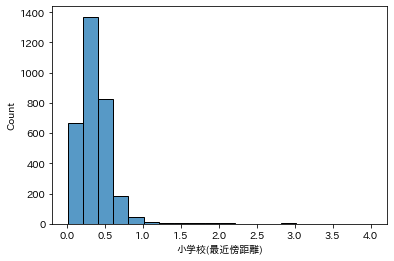

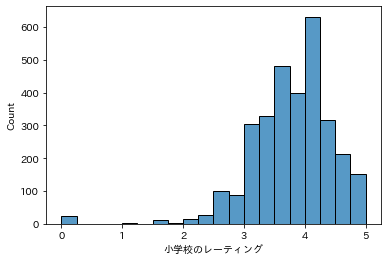

In [18]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

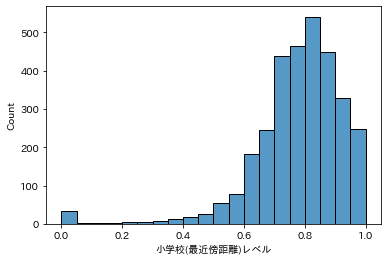

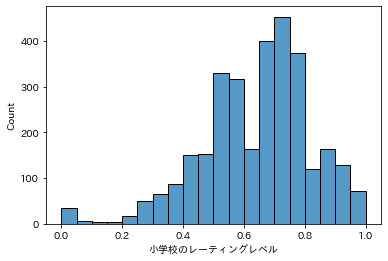

In [19]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

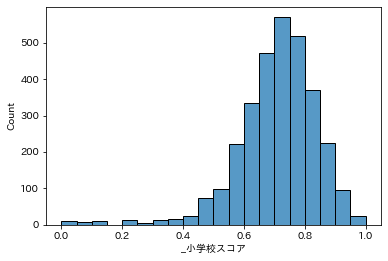

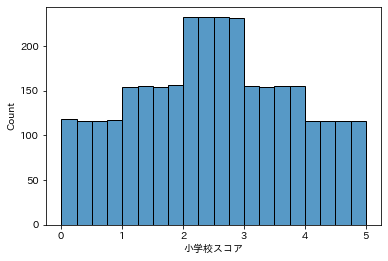

In [20]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

score_list = [score_sub_name, score_name]
for _score in score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

all_score_list += score_list

## 中学校スコア

In [21]:
score_name = '中学校スコア'
feature_list = {
    '中学校(最近傍距離)': {'high': False, 'outlier': True, 'weight': 1}, 
    '中学校のレーティング': {'high': True, 'outlier': True, 'weight': 0.5}, 
}
all_feature_list += list(feature_list.keys())

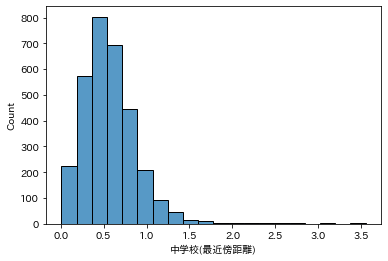

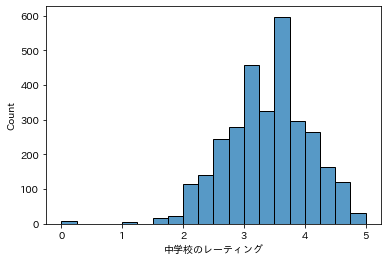

In [22]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

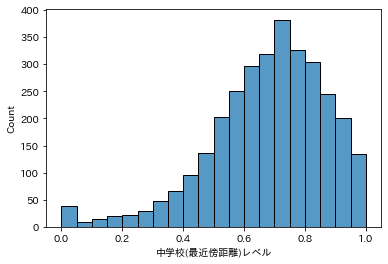

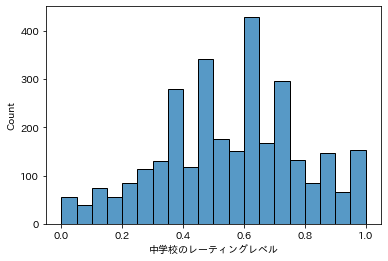

In [23]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

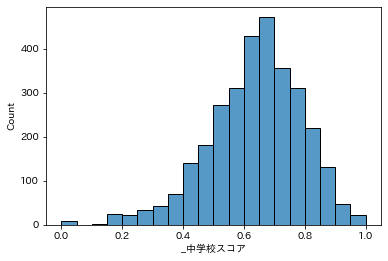

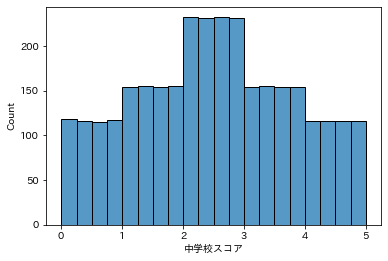

In [24]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

score_list = [score_sub_name, score_name]
for _score in score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

all_score_list += score_list

## 幼稚園スコア

In [25]:
score_name = '幼稚園スコア'
feature_list = {
    '幼稚園(最近傍距離)': {'high': False, 'outlier': True, 'weight': 1}, 
    '幼稚園のレーティング': {'high': True, 'outlier': True, 'weight': 0.3}, 
}
all_feature_list += list(feature_list.keys())

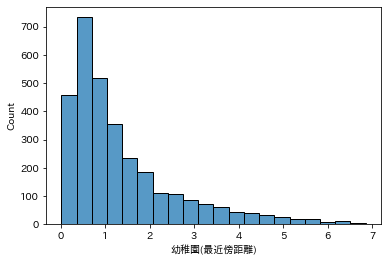

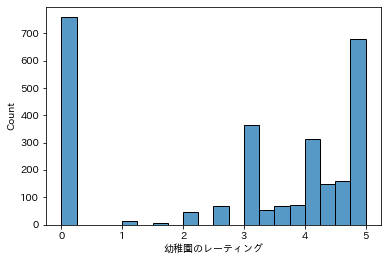

In [26]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

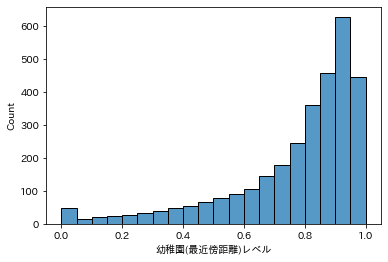

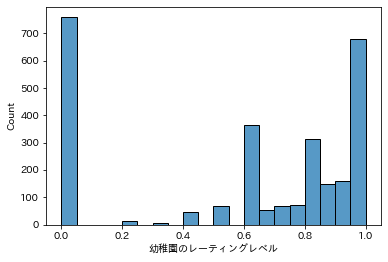

In [27]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

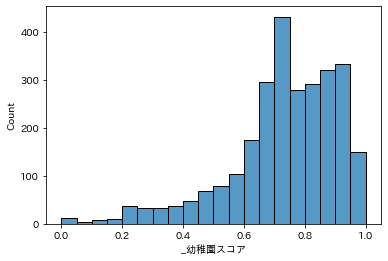

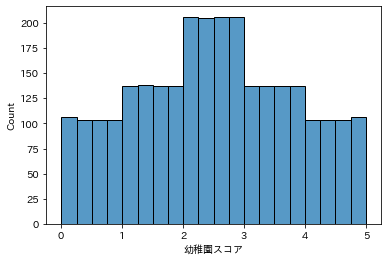

In [28]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

score_list = [score_sub_name, score_name]
for _score in score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

all_score_list += score_list

## 保存

In [29]:
all_feature_list

['小学校(最近傍距離)',
 '小学校のレーティング',
 '中学校(最近傍距離)',
 '中学校のレーティング',
 '幼稚園(最近傍距離)',
 '幼稚園のレーティング']

In [30]:
all_score_list

['_小学校スコア', '小学校スコア', '_中学校スコア', '中学校スコア', '_幼稚園スコア', '幼稚園スコア']

In [31]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + all_feature_list + ['最寄りの小学校', '最寄りの中学校', '最寄りの幼稚園'] + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

## 区ごとのスコア確認

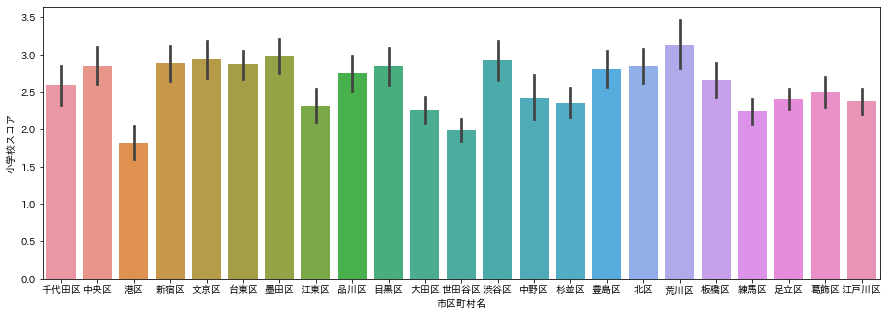

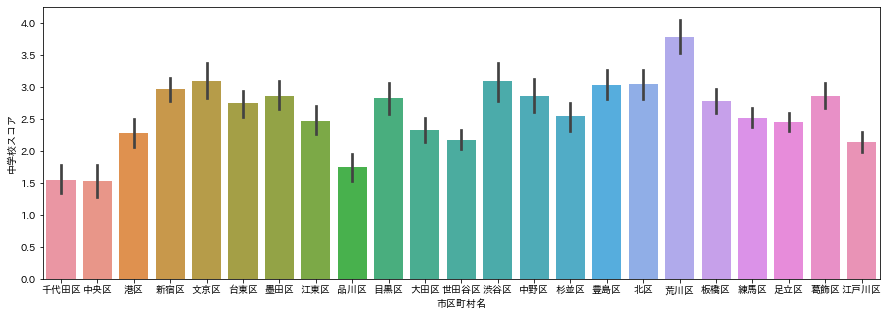

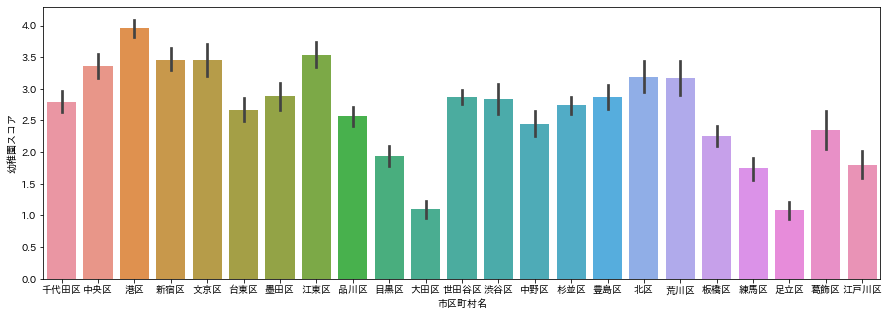

In [32]:
for _score in ['小学校スコア', '中学校スコア', '幼稚園スコア']:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_pop_master)
    plt.show()